<a href="https://colab.research.google.com/github/mayursk2000/Machnine-Learning-Practice/blob/main/AML_L2_Colab_Demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topics**: Data • Feature • End-to-End Pipeline

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

from pprint import pprint

np.random.seed(42)
pd.set_option("display.max_colwidth", 120)



# [Data Builder] - Create a toy dataset
Columns: `uid | age | state | review | label | income`

- `age` has missing values
- `state` has inconsistent formats (`"NY"` vs `"New York"`)
- `review` is short text
- `label` is a binary target (e.g., liked (1) vs not liked (0))


In [ ]:
uids = np.arange(1, 21)

# ages with some missing
ages = np.array([25, 31, np.nan, 41, 22, 59, np.nan, 35, 28, 47, 19, 40, 52, np.nan, 33, 29, 61, 38, 44, 27], dtype=float)

# inconsistent states
states = np.array(["NY", "New York", "NJ", "New Jersey", "CT",
                   "NY", "New York", "CT", "NJ", "New Jersey",
                   "NY", "CT", "New York", "NJ", "CT",
                   "New Jersey", "NY", "CT", "NJ", "New York"])

# simple text reviews
reviews = np.array([
    "great product loved it", "not good very bad", "average quality", "excellent and reliable",
    "terrible experience", "works fine", "amazing value", "poor packaging", "highly recommend",
    "waste of money", "decent and okay", "very useful tool", "bad quality", "not worth price",
    "fantastic build", "meh experience", "superb performance", "ok but slow", "solid choice",
    "do not recommend"
])

# labels roughly aligned with sentiment
labels = np.array([1,0,0,1,0,1,1,0,1,0, 1,1,0,0,1,0,1,0,1,0], dtype=int)

# skewed income
income = np.random.lognormal(mean=10.0, sigma=0.5, size=20)  # large values, skewed
income = np.round(income, 2)

df = pd.DataFrame({
    "uid": uids,
    "age": ages,
    "state": states,
    "review": reviews,
    "label": labels,
    "income": income
})
df.head(10)


,uid,age,state,review,label,income
0,1,25.0,NY,great product loved it,1,28236.11
1,2,31.0,New York,not good very bad,0,20555.17
2,3,NaN,NJ,average quality,0,30450.09
3,4,41.0,New Jersey,excellent and reliable,1,47170.07
4,5,22.0,CT,terrible experience,0,19592.92
5,6,59.0,NY,works fine,1,19593.08
6,7,NaN,New York,amazing value,1,48513.94
7,8,35.0,CT,poor packaging,0,32328.92
8,9,28.0,NJ,highly recommend,1,17418.06
9,10,47.0,New Jersey,waste of money,0,28890.84


# Data Cleaning

### Handling missing values

In [ ]:
df_missing = df.copy()

# 1. Drop rows with missing values
drop_rows = df_missing.dropna()
print("Dropped rows (missing removed):")
display(drop_rows.head())

# 2. Drop columns with too many missing values
drop_cols = df_missing.drop(columns=["age"])  # demo
print("\nDropped 'age' column as example:")
display(drop_cols.head())

Dropped rows (missing removed):


,uid,age,state,review,label,income
0,1,25.0,NY,great product loved it,1,28236.11
1,2,31.0,New York,not good very bad,0,20555.17
3,4,41.0,New Jersey,excellent and reliable,1,47170.07
4,5,22.0,CT,terrible experience,0,19592.92
5,6,59.0,NY,works fine,1,19593.08



Dropped 'age' column as example:


,uid,state,review,label,income
0,1,NY,great product loved it,1,28236.11
1,2,New York,not good very bad,0,20555.17
2,3,NJ,average quality,0,30450.09
3,4,New Jersey,excellent and reliable,1,47170.07
4,5,CT,terrible experience,0,19592.92


In [ ]:
# 3. Fill with constant (e.g., 'Unknown')
fill_constant = df_missing.fillna({"age": -1})
print("\nFilled missing age with -1 (constant):")
display(fill_constant.head())

# 4. Class-wise mean imputation (group by state)
classwise = df_missing.copy()
classwise["age"] = classwise.groupby("state")["age"].transform(
    lambda x: x.fillna(x.mean())
)
print("\nClass-wise mean imputation:")
display(classwise.head())

# 5. Add missing_flag column
flagged = df_missing.copy()
flagged["age_missing_flag"] = flagged["age"].isna().astype(int)
flagged["age"] = flagged["age"].fillna(flagged["age"].median())
print("\nAdded missing_flag column:")
display(flagged[["uid","age","age_missing_flag"]].head())



Filled missing age with -1 (constant):


,uid,age,state,review,label,income
0,1,25.0,NY,great product loved it,1,28236.11
1,2,31.0,New York,not good very bad,0,20555.17
2,3,-1.0,NJ,average quality,0,30450.09
3,4,41.0,New Jersey,excellent and reliable,1,47170.07
4,5,22.0,CT,terrible experience,0,19592.92



Class-wise mean imputation:


,uid,age,state,review,label,income
0,1,25.0,NY,great product loved it,1,28236.11
1,2,31.0,New York,not good very bad,0,20555.17
2,3,36.0,NJ,average quality,0,30450.09
3,4,41.0,New Jersey,excellent and reliable,1,47170.07
4,5,22.0,CT,terrible experience,0,19592.92



Added missing_flag column:


,uid,age,age_missing_flag
0,1,25.0,0
1,2,31.0,0
2,3,35.0,1
3,4,41.0,0
4,5,22.0,0


## Data Tranformation

### Normalization

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# toy data
df = pd.DataFrame({"age": [18, 25, 50, 80], "income": [2000, 5000, 15000, 40000]})

scaler = MinMaxScaler()
norm = scaler.fit_transform(df)

print("Original:\n", df)
print("\nNormalized [0,1]:\n", pd.DataFrame(norm, columns=df.columns))

Original:
    age  income
0   18    2000
1   25    5000
2   50   15000
3   80   40000

Normalized [0,1]:
         age    income
0  0.000000  0.000000
1  0.112903  0.078947
2  0.516129  0.342105
3  1.000000  1.000000


## Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
std = scaler.fit_transform(df)

print("Standardized (mean=0, std=1):\n", pd.DataFrame(std, columns=df.columns))

Standardized (mean=0, std=1):
         age    income
0 -1.038043 -0.903521
1 -0.750268 -0.702738
2  0.277497 -0.033464
3  1.510815  1.639722


## Visualization

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(42)

df = pd.DataFrame({
    "age":  [np.nan, 30, 28, np.nan, 35, 32, 45, np.nan, 50, 29,
             41, 36, np.nan, 55, 33, np.nan, 22, 48, 52, 44],
    "income": [50_000, 55_000, 52_000, 65_000, 58_000, 54_000, 70_000, 59_000, 75_000, 53_000,
               61_000, 56_000, 49_000, 80_000, 57_000, 85_000, 45_000, 68_000, 72_000, 66_000],
    "state": ["NY", "NY", "NY", "NJ", "NJ", "NJ", "CT", "CT", "CT", "NY",
              "NY", "NJ", "NJ", "CT", "CT", "CT", "NY", "NJ", "CT", "NY"]
})

df.head(10)

,age,income,state
0,NaN,50000,NY
1,30.0,55000,NY
2,28.0,52000,NY
3,NaN,65000,NJ
4,35.0,58000,NJ
5,32.0,54000,NJ
6,45.0,70000,CT
7,NaN,59000,CT
8,50.0,75000,CT
9,29.0,53000,NY


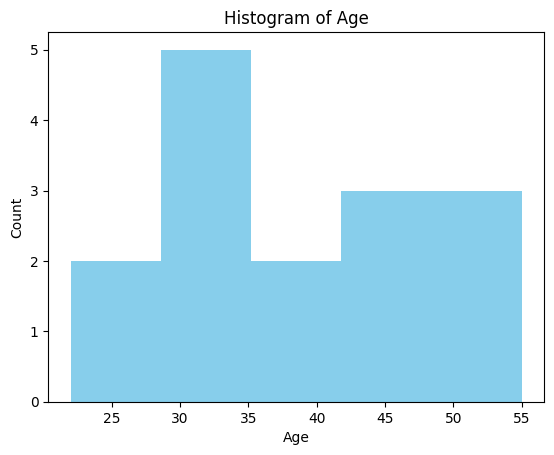

In [ ]:
# 1. Histogram → check missing + skew
plt.hist(df["age"].dropna(), bins=5, color="skyblue")
plt.title("Histogram of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

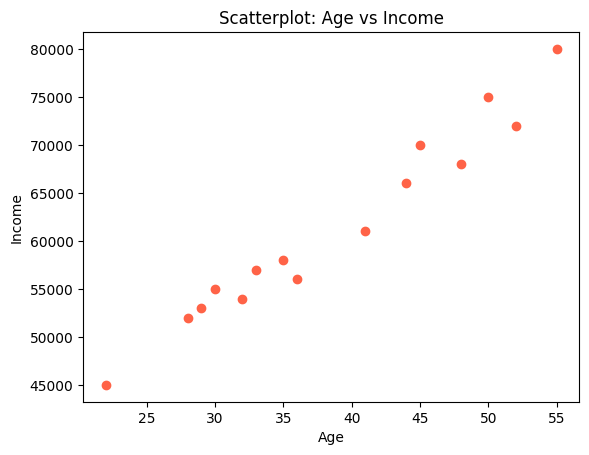

In [ ]:
# 2. Scatterplot → outliers & correlations
plt.scatter(df["age"], df["income"], c="tomato")
plt.title("Scatterplot: Age vs Income")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

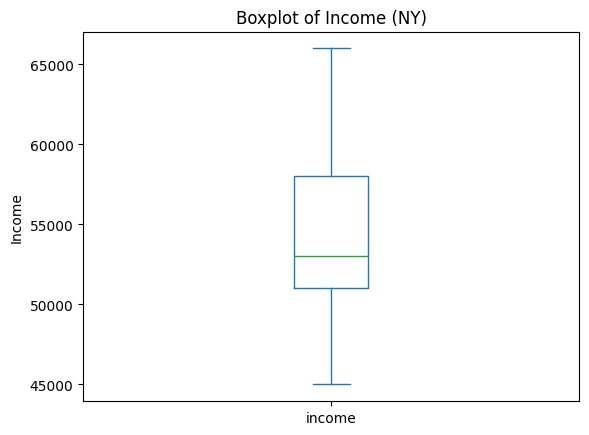

In [ ]:
# 3. Boxplot → group anomalies
df_ny = df[df["state"] == "NY"]

df_ny["income"].plot(kind="box")
plt.title("Boxplot of Income (NY)")
plt.ylabel("Income")
plt.show()

# Feature Engineering

One-Hot Encoding (Categorical)


In [ ]:
df_clean = df.copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
state_ohe = ohe.fit_transform(df_clean[["state"]])

print("One-hot categories:", ohe.categories_)
print("Encoded shape:", state_ohe.shape)
pd.DataFrame(state_ohe, columns=[f"state={c}" for c in ohe.categories_[0]]).head()

One-hot categories: [array(['CT', 'NJ', 'NY'], dtype=object)]
Encoded shape: (20, 3)


,state=CT,state=NJ,state=NY
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0



## Text


In [ ]:
# Tokenization

from transformers import BertTokenizer
from pprint import pprint

tok = BertTokenizer.from_pretrained("bert-base-uncased")

examples = ["unbelievable world!", "unbeliveable magic", "chatgptization Gemini Geminy", "OMG"]

for s in examples:
    print(f"\nSentence: {s}")
    print("Word-level:", s.split())
    print("Subword-level:", tok.tokenize(s))


Sentence: unbelievable world!
Word-level: ['unbelievable', 'world!']
Subword-level: ['unbelievable', 'world', '!']

Sentence: unbeliveable magic
Word-level: ['unbeliveable', 'magic']
Subword-level: ['un', '##bel', '##ive', '##able', 'magic']

Sentence: chatgptization Gemini Geminy
Word-level: ['chatgptization', 'Gemini', 'Geminy']
Subword-level: ['chat', '##gp', '##ti', '##zation', 'gemini', 'gem', '##iny']

Sentence: OMG
Word-level: ['OMG']
Subword-level: ['om', '##g']


In [ ]:
# BoW

from sklearn.feature_extraction.text import CountVectorizer

docs = ["Cats are great pets", "Dogs are great companions", "I love my cat"]
bow = CountVectorizer()
X_bow = bow.fit_transform(docs)

print("Vocabulary:", bow.get_feature_names_out())
print("BoW matrix:\n", X_bow.toarray())

Vocabulary: ['are' 'cat' 'cats' 'companions' 'dogs' 'great' 'love' 'my' 'pets']
BoW matrix:
 [[1 0 1 0 0 1 0 0 1]
 [1 0 0 1 1 1 0 0 0]
 [0 1 0 0 0 0 1 1 0]]


In [ ]:
# TF-IDF = Term Frequency * Inverse Document Frequency
# - Term Frequency (TF): how often a term appears in a document
# - Inverse Document Frequency (IDF): downweights common terms that appear in many documents
#   -> aka words that are frequent in one doc but rare overall get higher weights

from sklearn.feature_extraction.text import TfidfVectorizer

# Tiny corpus: each string is a "document"
docs = [
    "great product loved it",
    "not good very bad",
    "excellent reliable product",
    "bad packaging not good",
    "highly recommend amazing value"
]

tfidf = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf.fit_transform(docs)

print("Vocabulary:", tfidf.get_feature_names_out())
print("TF-IDF matrix:\n", X_tfidf.toarray().round(2))

Vocabulary: ['amazing' 'bad' 'excellent' 'good' 'great' 'highly' 'loved' 'packaging'
 'product' 'recommend' 'reliable' 'value']
TF-IDF matrix:
 [[0.   0.   0.   0.   0.61 0.   0.61 0.   0.5  0.   0.   0.  ]
 [0.   0.71 0.   0.71 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.61 0.   0.   0.   0.   0.   0.5  0.   0.61 0.  ]
 [0.   0.53 0.   0.53 0.   0.   0.   0.66 0.   0.   0.   0.  ]
 [0.5  0.   0.   0.   0.   0.5  0.   0.   0.   0.5  0.   0.5 ]]


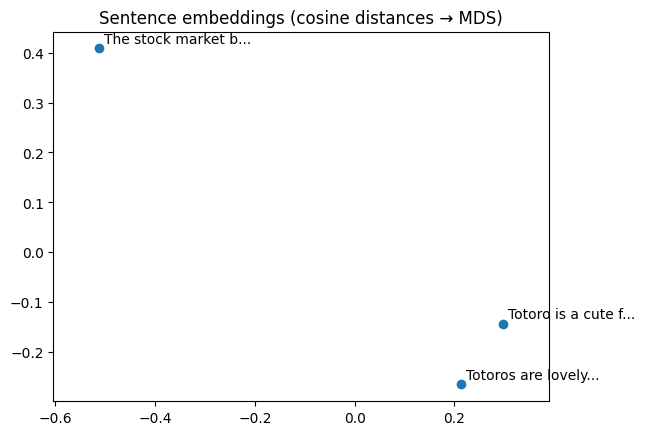

In [ ]:
# Embeddings

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import numpy as np

# Two very similar + one very different
sents = [
    "Totoro is a cute friend.",
    "Totoros are lovely friends",
    "The stock market bumped yesterday."
]

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(sents, normalize_embeddings=True)  # L2-normalized

# Use MDS on cosine distances to preserve pairwise geometry in 2D
D = cosine_distances(emb)
xy = MDS(n_components=2, dissimilarity="precomputed", random_state=0).fit_transform(D)

# Plot
plt.scatter(xy[:,0], xy[:,1])
for i, s in enumerate(sents):
    plt.text(xy[i,0]+0.01, xy[i,1]+0.01, s[:18]+"...")
plt.title("Sentence embeddings (cosine distances → MDS)")
plt.axis("equal")   # equal scale on both axes
plt.show()


## Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color, img_as_float
from skimage.filters import sobel

import torch
import torch.nn as nn
from torchvision import models, transforms

RGB shape: (512, 512, 3) | dtype: float64 | range: (np.float64(0.0), np.float64(1.0))
Gray shape: (512, 512) | dtype: float64 | range: (np.float64(0.0), np.float64(1.0))


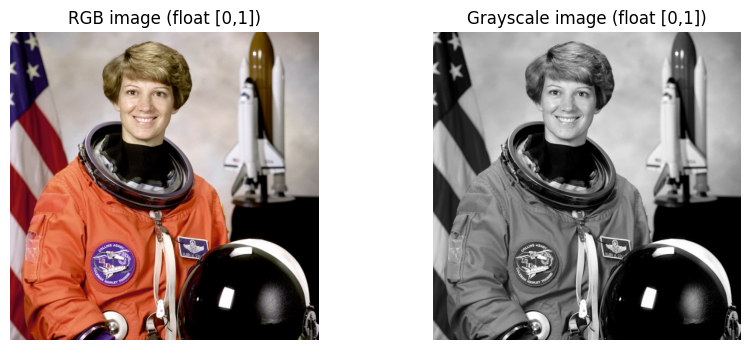

Normalized gray range: (np.float64(0.0), np.float64(0.9999999989999999))


In [ ]:
# Use an RGB sample image
img_rgb = img_as_float(data.astronaut())   # values in [0,1], shape (H,W,3)
img_gray = color.rgb2gray(img_rgb)         # shape (H,W), float in [0,1]

print("RGB shape:", img_rgb.shape, "| dtype:", img_rgb.dtype, "| range:", (img_rgb.min(), img_rgb.max()))
print("Gray shape:", img_gray.shape, "| dtype:", img_gray.dtype, "| range:", (img_gray.min(), img_gray.max()))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("RGB image (float [0,1])")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale image (float [0,1])")
plt.axis("off")
plt.show()

# Example of min-max normalization to [0,1] (already in [0,1], but here is the pattern)
img_gray_minmax = (img_gray - img_gray.min()) / (np.ptp(img_gray) + 1e-9)
print("Normalized gray range:", (img_gray_minmax.min(), img_gray_minmax.max()))


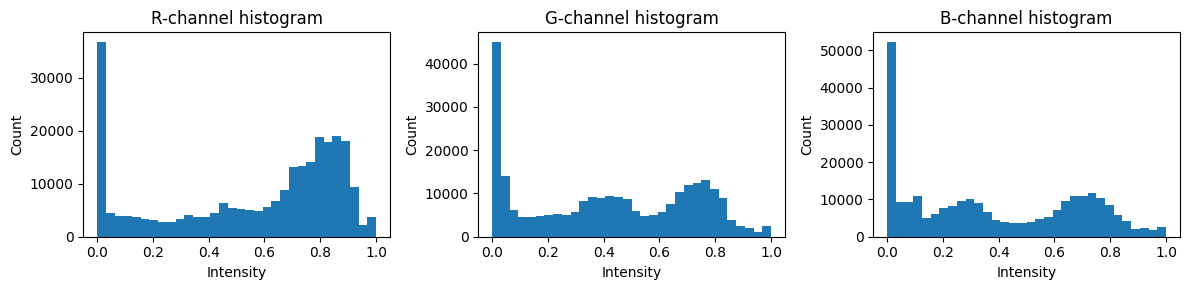

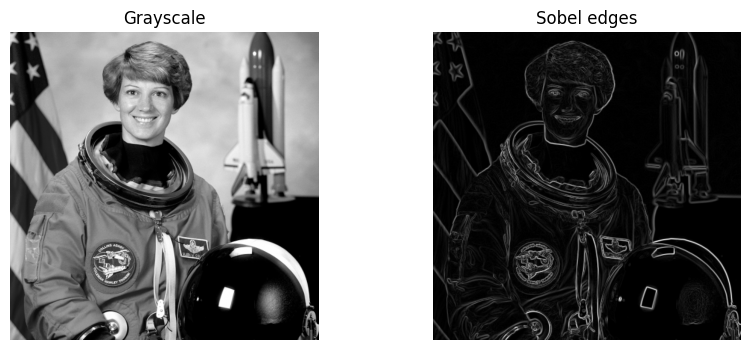

In [ ]:
# Per-channel histograms (RGB)
plt.figure(figsize=(12,3))
for i, ch in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    plt.hist(img_rgb[..., i].ravel(), bins=32)
    plt.title(f"{ch}-channel histogram")
    plt.xlabel("Intensity")
    plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Sobel edges on grayscale
edges = sobel(img_gray)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edges, cmap="gray")
plt.title("Sobel edges")
plt.axis("off")
plt.show()


In [ ]:
# Prepare torchvision transforms for ImageNet-pretrained models
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),  # -> [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Convert skimage image (H,W,3) float[0,1] to model input (1,3,224,224)
x = preprocess((img_rgb*255).astype(np.uint8)).unsqueeze(0)

# Load pretrained ResNet18 and take embeddings from the penultimate layer
weights = models.ResNet18_Weights.DEFAULT
resnet18 = models.resnet18(weights=weights)
resnet18.eval()

# Remove final classification layer to get a 512-dim embedding
backbone = nn.Sequential(*list(resnet18.children())[:-1])  # up to avgpool
with torch.no_grad():
    feat = backbone(x).squeeze().numpy()  # shape (512,)

print("Embedding shape:", feat.shape)
print("First 10 dims:", np.round(feat[:10], 4))

Embedding shape: (512,)
First 10 dims: [1.0005 2.106  2.3042 0.3677 0.7896 1.3859 1.7567 0.5307 3.272  1.3542]


# Feature Selection


## LASSO (Synthetic Regression)
Create a synthetic regression dataset with a few informative features, fit LassoCV, and inspect non-zero coefficients.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

# -------------------------
# 1) Make a "sparse truth" dataset
#    - Many features, only a few truly matter
# -------------------------
n, d = 120, 30                 # more features than signals → easier to prune
rng = np.random.RandomState(42)
X = rng.randn(n, d)

# Only 4 features are truly informative; the rest are pure noise
true_coef = np.zeros(d)
signal_idx = [0, 1, 4, 7]
true_coef[signal_idx] = [3.0, -2.5, 1.2, 2.0]

# Generate y with modest noise
y = X @ true_coef + rng.randn(n) * 0.6

# -------------------------
# 2) Fit LASSO with a range of stronger alphas
#    - This encourages exact zeros for irrelevant features
# -------------------------
alphas = np.logspace(-2, 0.5, 60)  # ~0.01 → ~3.16
lasso = LassoCV(alphas=alphas, cv=5, random_state=42).fit(X, y)
coef = lasso.coef_

# -------------------------
# 3) Inspect sparsity and accuracy
# -------------------------
nz_idx = np.where(np.abs(coef) > 1e-8)[0].tolist()  # non-zero selected features
print("True non-zero idx:           ", signal_idx)
print("LASSO selected non-zero idx: ", nz_idx)
print("\nTrue coefficients (non-zeros first 10 dims):")
print(np.round(true_coef[:10], 3))
print("\nLASSO-estimated coefficients (first 10 dims):")
print(np.round(coef[:10], 3))

print("\n#Non-zeros selected:", len(nz_idx), "out of", d)
print("Train MSE:          ", round(mean_squared_error(y, lasso.predict(X)), 3))



True non-zero idx:            [0, 1, 4, 7]
LASSO selected non-zero idx:  [0, 1, 4, 7, 9, 16, 19, 27, 29]

True coefficients (non-zeros first 10 dims):
[ 3.  -2.5  0.   0.   1.2  0.   0.   2.   0.   0. ]

LASSO-estimated coefficients (first 10 dims):
[ 3.004 -2.431  0.    -0.     1.141  0.    -0.     1.899 -0.    -0.04 ]

#Non-zeros selected: 9 out of 30
Train MSE:           0.294
